## Prerequisits

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from scipy.sparse import csr_matrix

# import warnings
# warnings.filterwarnings('ignore')

### Rollcalls data

In [6]:
members = pd.read_csv('irt_files/S109_members.csv')
votes = pd.read_csv('irt_files/S109_votes.csv')
rollcalls = pd.read_csv('irt_files/S109_rollcalls.csv')

print(f"Loaded {len(votes)} votes, {len(members)} members, {len(rollcalls)} roll calls")

Loaded 65145 votes, 102 members, 645 roll calls


In [7]:
"""
Preprocess the data to create vote matrix and metadata

IRT CONNECTION: This creates the response matrix where:
- Rows = respondents (legislators, analogous to students in educational IRT)
- Columns = items (roll call votes, analogous to test questions in educational IRT)
- Values = binary responses (1=Yea/correct, 0=Nay/incorrect)
"""

# Filter for Senate only (chamber == 'Senate')
# votes_senate = votes[votes['chamber'] == 'Senate'].copy()
# members_senate = members[members['chamber'] == 'Senate'].copy()
# rollcalls_senate = rollcalls[rollcalls['chamber'] == 'Senate'].copy()
votes_senate = votes.copy()
members_senate = members.copy()
rollcalls_senate = rollcalls.copy()

# Create mapping dictionaries
member_to_idx = {icpsr: idx for idx, icpsr in enumerate(sorted(members_senate['icpsr'].unique()))}
rollcall_to_idx = {roll: idx for idx, roll in enumerate(sorted(rollcalls_senate['rollnumber'].unique()))}

# Create reverse mappings
idx_to_member = {idx: icpsr for icpsr, idx in member_to_idx.items()}
idx_to_rollcall = {idx: roll for roll, idx in rollcall_to_idx.items()}

n_members = len(member_to_idx)
n_rollcalls = len(rollcall_to_idx)

print(f"Matrix dimensions: {n_members} members x {n_rollcalls} roll calls")

# Initialize vote matrix with NaN (missing votes)
# IRT CONNECTION: This is the classic IRT response matrix R[person, item]
vote_matrix = np.full((n_members, n_rollcalls), np.nan)

# Fill in the vote matrix
# Cast codes: 1,2,3 = Yea, 4,5,6 = Nay, 7,8,9 = Not voting/Present
for _, row in votes_senate.iterrows():
    if row['icpsr'] in member_to_idx and row['rollnumber'] in rollcall_to_idx:
        member_idx = member_to_idx[row['icpsr']]
        roll_idx = rollcall_to_idx[row['rollnumber']]
        
        # Convert cast codes to binary votes
        # IRT CONNECTION: Converting to binary responses (0/1) like correct/incorrect in educational testing
        if row[f'cast_code'] in [1, 2, 3]:  # Yea votes
            vote_matrix[member_idx, roll_idx] = 1
        elif row[f'cast_code'] in [4, 5, 6]:  # Nay votes
            vote_matrix[member_idx, roll_idx] = 0
        

# print(vote_matrix)

# Create member info dataframe with proper ordering
member_info = []
for idx in range(n_members):
    icpsr = idx_to_member[idx]
    member_row = members_senate[members_senate['icpsr'] == icpsr].iloc[0]
    member_info.append({
        'idx': idx,
        'icpsr': icpsr,
        'bioname': member_row['bioname'],
        'state_abbrev': member_row['state_abbrev'],
        'party_code': member_row['party_code'],
        'nominate_dim_1': member_row['nominate_dim1'],
        'nominate_dim_2': member_row['nominate_dim2']
    })

member_info_df = pd.DataFrame(member_info)
# print(member_info_df)

# Convert party codes to letters (100=D, 200=R, others=I)
party_map = {100: 'D', 200: 'R', 328: 'I'}
member_info_df['party'] = member_info_df['party_code'].map(party_map).fillna('U')

# Remove roll calls with too few votes or unanimous votes
# IRT CONNECTION: Similar to removing items that are too easy/hard or have no discrimination
valid_rollcalls = []
valid_vote_matrix = []

for roll_idx in range(n_rollcalls):
    votes_col = vote_matrix[:, roll_idx]
    valid_votes = votes_col[~np.isnan(votes_col)]
    
    if len(valid_votes) >= 2:  # At least 10 votes
        yea_count = np.sum(valid_votes == 1)
        nay_count = np.sum(valid_votes == 0)
        
        # Skip unanimous votes (no discrimination power, like items everyone gets right/wrong)
        if yea_count > 0 and nay_count > 0:
            valid_rollcalls.append(roll_idx)
            valid_vote_matrix.append(votes_col)

vote_matrix_clean = np.column_stack(valid_vote_matrix)

print(f"After filtering: {vote_matrix_clean.shape[0]} members x {vote_matrix_clean.shape[1]} roll calls")

vote_matrix = vote_matrix_clean

pd.DataFrame(vote_matrix).to_csv("irt_files/rollcalls_vote_matrix.csv", index=False)

Matrix dimensions: 102 members x 645 roll calls


After filtering: 102 members x 544 roll calls


### LLM Response data

In [115]:
model = "gemma-2-9b-it"
# votes = pd.read_csv(f"analysis/{model}_votes.csv")
# print(votes.isna().sum())
# response_cols = [col for col in votes.columns if col not in ['category', 'q_id']]
# votes = votes[response_cols].T

votes_1 = pd.read_csv(f"analysis/{model}_conservative_steering_votes.csv")
print(votes_1.isna().sum())
votes_2 = pd.read_csv(f"analysis/{model}_liberal_steering_votes.csv")
print(votes_2.isna().sum())
response_cols = [col for col in votes_1.columns if col not in ['category', 'q_id']]
      
votes_1 = votes_1[response_cols].rename(columns={col: f"-ve_{col[9:]}" for col in response_cols})
votes_2 = votes_2[response_cols].rename(columns={col: f"+ve_{col[9:]}" for col in response_cols})

votes = pd.concat([votes_1.T, votes_2.T])

vote_matrix = votes.values
member_info_df = pd.DataFrame({'idx': list(range(len(votes))),
                   'bioname': votes.index,
                   'party': ['U']*len(votes)})

q_id                                  0
steering_caa_argument_none            0
steering_sta_argument_none            0
steering_caa_argument_liberal         0
steering_sta_argument_liberal         0
steering_caa_argument_conservative    0
steering_sta_argument_conservative    0
category                              0
dtype: int64
q_id                                  0
steering_caa_argument_none            0
steering_sta_argument_none            0
steering_caa_argument_liberal         0
steering_sta_argument_liberal         0
steering_caa_argument_conservative    0
steering_sta_argument_conservative    0
category                              0
dtype: int64


## Check inputs

In [8]:
print(vote_matrix.shape)
member_info_df

(102, 544)


,idx,icpsr,bioname,state_abbrev,party_code,nominate_dim_1,nominate_dim_2,party
0,0,1366,"BYRD, Robert Carlyle",WV,100,-0.309,0.729,D
1,1,4812,"INOUYE, Daniel Ken",HI,100,-0.319,0.062,D
2,2,10808,"KENNEDY, Edward Moore (Ted)",MA,100,-0.443,-0.490,D
3,3,12109,"STEVENS, Theodore Fulton (Ted)",AK,200,0.219,-0.500,R
4,4,13039,"SARBANES, Paul Spyros",MD,100,-0.435,-0.221,D
...,...,...,...,...,...,...,...,...
97,97,49903,"VOINOVICH, George Victor",OH,200,0.239,-0.803,R
98,98,49905,"CHAFEE, Lincoln Davenport",RI,200,0.003,-1.000,R
99,99,94240,"JEFFORDS, James Merrill",VT,328,-0.277,-0.603,I
100,100,94659,"SHELBY, Richard C.",AL,200,0.446,0.570,R


In [9]:
n_dims=2

n_members, n_rollcalls = vote_matrix.shape

# Create masks for observed votes
observed_mask = ~np.isnan(vote_matrix)

# Convert to binary format for observed votes only
vote_obs = vote_matrix[observed_mask].astype(int)

# Get indices for observed votes
member_idx, rollcall_idx = np.where(observed_mask)


# Assign each rollcall to a dimension (random assignment)
np.random.seed(42)  # for reproducibility
rollcall_to_dim = np.random.randint(0, n_dims, size=n_rollcalls)

# Create dimension index for each observation
dimension_idx = rollcall_to_dim[rollcall_idx]

print(f"Fitting {n_dims}D ideal point model...")
print("n_members:", n_members)
print("n_rollcalls:", n_rollcalls)
print("n_observations:", len(vote_obs))
print("Rollcalls per dimension:", np.bincount(rollcall_to_dim))

Fitting 2D ideal point model...
n_members: 102
n_rollcalls: 544
n_observations: 53198
Rollcalls per dimension: [265 279]


## IRT Using Stan
***

In [10]:
# Create Stan data dictionary
stan_data = {
    'J': n_members,
    'K': n_rollcalls, 
    'N': len(vote_obs),
    'D': n_dims,
    'jj': member_idx+1, # starting idx 1
    'kk': rollcall_idx+1, # starting idx 1
    'y': vote_obs
}

# import numpy as np

# # Choose 3 legislators to fix (you can pick based on domain knowledge)
# # For example, most liberal, most conservative, and someone in between
# fixed_legislators = [0, 1, 2]  # indices in your data (0-based)

# # Define their positions in 2D space
# # Common approach: place them at corners of a triangle
# fixed_positions = np.array([
#     [-1.0, -1.0],  # bottom-left
#     [ 1.0, -1.0],  # bottom-right  
#     [ 0.0,  1.0]   # top-center
# ])

# stan_data = {
#     'J': n_members,
#     'K': n_rollcalls, 
#     'N': len(vote_obs),
#     'D': n_dims,
#     'jj': member_idx+1,
#     'kk': rollcall_idx+1,
#     'y': vote_obs,
#     'n_fixed': 3,
#     'fixed_legs': [x+1 for x in fixed_legislators],  # convert to 1-based indexing
#     'fixed_pos': fixed_positions
# }
stan_data

{'J': 102,
 'K': 544,
 'N': 53198,
 'D': 2,
 'jj': array([  1,   1,   1, ..., 102, 102, 102]),
 'kk': array([  1,   2,   3, ..., 539, 541, 544]),
 'y': array([0, 0, 0, ..., 1, 1, 1])}

In [14]:
import arviz as az
from cmdstanpy import CmdStanModel

stan_file = os.path.join('irt_files/MIRT.stan')
model = CmdStanModel(stan_file=stan_file)
# print(model)
# print(json.dumps(model.exe_info(), indent=4))

11:45:18 - cmdstanpy - INFO - compiling stan file /home/skabi9001/activation_steering/llm-ideological-depth/irt_files/MIRT.stan to exe file /home/skabi9001/activation_steering/llm-ideological-depth/irt_files/MIRT
11:45:37 - cmdstanpy - INFO - compiled model executable: /home/skabi9001/activation_steering/llm-ideological-depth/irt_files/MIRT


In [ ]:
n_samples=500
n_tune=500

fit = model.sample(
    data=stan_data, chains=4, 
    iter_sampling=n_samples, 
    iter_warmup=n_tune,
    # show_console=True
)

11:45:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
inference_data = az.from_cmdstanpy(fit)
inference_data

Inference data with groups:
	> posterior
	> sample_stats

### Diagnosis

In [ ]:
# print(fit.diagnose())

In [ ]:
# import matplotlib.cm as cm

# n_chains = len(inference_data.posterior.chain)
# n_vars = len(inference_data.posterior.data_vars)
# print(f"Number of parameter variables: {n_vars}")

# # cmap = cm.get_cmap('ocean')  # or 'plasma', 'tab10', etc.
# # colors = [cmap(i / (n_chains - 1)) for i in range(n_chains)]

# az.plot_trace(inference_data, figsize=(20, 2*n_vars), legend=False) #chain_prop={'color': colors},
# plt.tight_layout()
# plt.show()

### IDEAL Points

In [ ]:
"""
Extract mean ideal points from trace

IRT CONNECTION: These are the estimated person parameters (abilities/traits)
In educational IRT: student ability estimates
In political IRT: legislator ideological position estimates
"""
ideal_points_samples = inference_data.posterior['theta'].values
# Average across chains and samples to get point estimates
ideal_points = np.mean(ideal_points_samples, axis=(0, 1))

# Print some diagnostics
print(f"\nIdeal points shape: {ideal_points.shape}")
print("Ideal_points_sample:")
print(ideal_points[:5])
print(f"Dimension 1 range: [{ideal_points[:, 0].min():.3f}, {ideal_points[:, 0].max():.3f}]")
print(f"Dimension 2 range: [{ideal_points[:, 1].min():.3f}, {ideal_points[:, 1].max():.3f}]")



Ideal points shape: (102, 2)
Ideal_points_sample:
[[ 0.99070108  0.81197543]
 [-0.04878611  0.90164995]
 [-0.21424446  1.59168886]
 [-0.06295549 -0.69529142]
 [-0.17319739  1.39778727]]
Dimension 1 range: [-1.124, 0.991]
Dimension 2 range: [-1.426, 1.662]


### Check Correlations

In [ ]:
from scipy.stats import pearsonr

merged_df_1 = member_info_df.join(pd.DataFrame(ideal_points, columns=['ideal_dim_1', 'ideal_dim_2']))
# print(merged_df)
# Calculate correlations
corr_dim1, p_value_dim1 = pearsonr(merged_df_1['nominate_dim_1'], merged_df_1['ideal_dim_1'])
corr_dim2, p_value_dim2 = pearsonr(merged_df_1['nominate_dim_2'], merged_df_1['ideal_dim_2'])

print("IRT-Stan v DW Nominate Correlation:")
print("Dimension 1:")
print(f"Correlation: {corr_dim1:.6f}")
print(f"P-value: {p_value_dim1:.6f}")

print("Dimension 2:")
print(f"Correlation: {corr_dim2:.6f}")
print(f"P-value: {p_value_dim2:.6f}\n\n")

# member_info_df['members_abbv'] = member_info_df.apply(lambda row: f"{row['bioname'].split(', ')[0]} ({row['party']} {row['state_abbrev']})", axis=1)

# R_manual_df = pd.read_csv("irt_files/ideal_points_R_manual_files.csv")
# R_manual_df.columns =['members_abbv','ideal_dim_1', 'ideal_dim_2']
# merged_df_2 = member_info_df.join(R_manual_df.set_index('members_abbv'), on='members_abbv', how='inner')
# corr_dim1, p_value_dim1 = pearsonr(merged_df_2['nominate_dim_1'], merged_df_2['ideal_dim_1'])
# corr_dim2, p_value_dim2 = pearsonr(merged_df_2['nominate_dim_2'], merged_df_2['ideal_dim_2'])
# print("IDEAL-R Manual v DW Nominate Correlation:")
# print("Dimension 1:")
# print(f"Correlation: {corr_dim1:.6f}")
# print(f"P-value: {p_value_dim1:.6f}")

# print("Dimension 2:")
# print(f"Correlation: {corr_dim2:.6f}")
# print(f"P-value: {p_value_dim2:.6f}\n\n")

# R_manual_df = pd.read_csv("irt_files/ideal_points_R_preloaded_files.csv")
# R_manual_df.columns =['members_abbv','ideal_dim_1', 'ideal_dim_2']
# merged_df_3 = member_info_df.join(R_manual_df.set_index('members_abbv'), on='members_abbv', how='inner')
# corr_dim1, p_value_dim1 = pearsonr(merged_df_3['nominate_dim_1'], merged_df_3['ideal_dim_1'])
# corr_dim2, p_value_dim2 = pearsonr(merged_df_3['nominate_dim_2'], merged_df_3['ideal_dim_2'])
# print("IDEAL-R Builtin v DW Nominate Correlation:")
# print("Dimension 1:")
# print(f"Correlation: {corr_dim1:.6f}")
# print(f"P-value: {p_value_dim1:.6f}")

# print("Dimension 2:")
# print(f"Correlation: {corr_dim2:.6f}")
# print(f"P-value: {p_value_dim2:.6f}\n\n")


IRT-Stan v DW Nominate Correlation:
Dimension 1:
Correlation: -0.053803
P-value: 0.591217
Dimension 2:
Correlation: -0.102361
P-value: 0.305953




### Plot IDEAL Points

Creating plot...


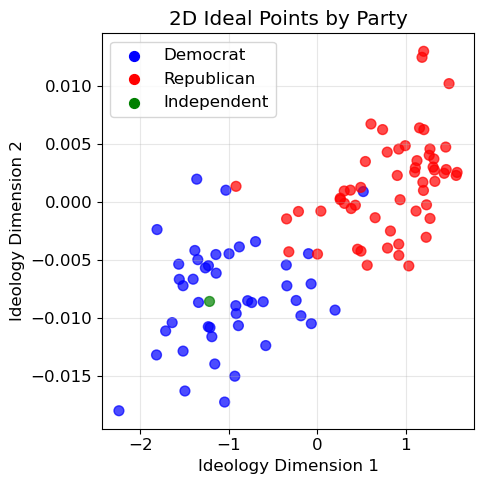

In [ ]:
"""
Create the ideal points plot matching R output

IRT CONNECTION: This visualizes the estimated person parameters (θ) in 2D space
Each point represents a legislator's estimated ideological position
"""
print("Creating plot...")

# Set up colors
party_colors = {'D': 'blue', 'R': 'red', 'I': 'green', 'U': 'purple'}
colors = [party_colors[party] for party in member_info_df['party']]

# Create plot
# plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 12, 'figure.figsize': (5,5)})

# Scatter plot of ideal points (IRT person parameters)
plt.scatter(ideal_points[:, 0], ideal_points[:, 1], 
            c=colors, s=50, alpha=0.7)

# Add labels for each point
for i, row in member_info_df.iterrows():
    # Format name like R output: "LASTNAME (PARTY STATE)"
    name_parts = row['bioname'].split(', ')
    if len(name_parts) >= 2:
        lastname = name_parts[0]
    else:
        lastname = row['bioname']
    
    # label = f"{lastname} ({row['party']} {row['state_abbrev']})"
    # label = f"{lastname} ({row['party']})"
    label = "" #row['bioname']
    
    plt.annotate(label, 
                (ideal_points[i, 0], ideal_points[i, 1]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8, rotation=-15, 
                ha='left', va='center', rotation_mode='anchor')

# Formatting
plt.xlabel('Ideology Dimension 1')  # First IRT dimension (usually liberal-conservative)
plt.ylabel('Ideology Dimension 2')  # Second IRT dimension
plt.title('2D Ideal Points by Party')

# Legend
legend_elements = [
    plt.scatter([], [], c='blue', s=50, label='Democrat'),
    plt.scatter([], [], c='red', s=50, label='Republican'),
    plt.scatter([], [], c='green', s=50, label='Independent'),
    # plt.scatter([], [], c='purple', s=100, label='LLM')
]
plt.legend(handles=legend_elements)#, loc='upper left'

plt.grid(True, alpha=0.3)
plt.tight_layout()
# print(f"Saving figure at ideal_points_llms_round_{round}.png")
# plt.savefig(f"ideal_points_llms_round_{round}.png")
plt.show()


### Summary

In [ ]:
print("\nSummary by party:")
for party in ['D', 'R', 'I', 'U']:
    party_mask = member_info_df['party'] == party
    if party_mask.any():
        party_points = ideal_points[party_mask]
        print(f"{party}: n={np.sum(party_mask)}, "
                f"Dim1 mean={np.mean(party_points[:, 0]):.3f}, "
                f"Dim2 mean={np.mean(party_points[:, 1]):.3f}")

print("\nIRT-based ideal point analysis complete!")


Summary by party:
D: n=45, Dim1 mean=2.034, Dim2 mean=0.054
R: n=56, Dim1 mean=-1.703, Dim2 mean=-0.028
I: n=1, Dim1 mean=2.319, Dim2 mean=-0.095

IRT-based ideal point analysis complete!


## IRT Using PyMC

***

In [22]:
import pymc as pm

In [ ]:
"""
Fit the ideal point model using PyMC

IRT CONNECTION: This implements a multidimensional IRT model where:
- ideal_points = person abilities/traits (θ in IRT notation)
- discrimination = item discrimination parameters (a in IRT notation) 
- difficulty = item difficulty parameters (b in IRT notation)
- The model: P(Y=1) = logit^(-1)(a*(θ - b)) in 1D, or a'*θ - b in multidimensional case
"""


cov_matrix = np.array([[1.0, 0],    # No correlation between dimensions
                       [0, 1.0]])

with pm.Model() as model:
    # =============================================================================
    # IRT COMPONENT 1: PERSON PARAMETERS (θ - ability/trait parameters)
    # =============================================================================
    # Prior for ideal points (members) - multivariate normal
    # In educational IRT: these would be student abilities
    # In political IRT: these are legislators' ideological positions
    ideal_points_raw = pm.MvNormal(
        'ideal_points_raw', 
        mu=np.zeros(n_dims), 
        # cov=np.eye(n_dims),
        cov= cov_matrix,
        shape=(n_members, n_dims)
    )
    
    # Center ideal points (subtract mean) - IDENTIFICATION CONSTRAINT
    # IRT CONNECTION: This is a common identification constraint in IRT
    # (similar to setting mean ability to 0 in educational testing)
    ideal_points = pm.Deterministic(
        'ideal_points',
        ideal_points_raw - pm.math.mean(ideal_points_raw, axis=0)
    )
    # ideal_points = pm.Normal("ideal_points", 
    #                          mu=0, sigma=1, 
    #                          shape=(n_members, n_dims))
    # =============================================================================
    # IRT COMPONENT 2: ITEM PARAMETERS
    # =============================================================================
    
    # IRT DISCRIMINATION PARAMETERS (a parameters)
    # In educational IRT: how well each item discriminates between high/low ability students
    # In political IRT: how well each vote discriminates along ideological dimensions
    discrimination = pm.Normal(
        'discrimination',
        mu=0, sigma=1,
        shape=(n_rollcalls, n_dims)
    )
    
    # IRT DIFFICULTY PARAMETERS (b parameters) 
    # In educational IRT: how difficult each item is
    # In political IRT: how "conservative" or "liberal" each vote is (the cutpoint)
    difficulty = pm.Normal(
        'difficulty',
        mu=0, sigma=1,
        shape=n_rollcalls
    )
    
    # =============================================================================
    # IRT COMPONENT 3: RESPONSE FUNCTION
    # =============================================================================
    # Linear predictor for observed votes
    # IRT CONNECTION: This implements the multidimensional IRT response function:
    # logit(P(Y_ij = 1)) = a_j' * θ_i - b_j
    # where:
    # - Y_ij = response of person i to item j
    # - θ_i = ideal point (ability) of person i  
    # - a_j = discrimination vector for item j
    # - b_j = difficulty of item j
    linear_pred = (
        pm.math.sum(
            ideal_points[member_idx] * discrimination[rollcall_idx], 
            axis=1
        ) - difficulty[rollcall_idx]
    )
    
    # IRT LIKELIHOOD: Bernoulli with logit link
    # This is the standard IRT likelihood function
    # P(Y_ij = 1 | θ_i, a_j, b_j) = logit^(-1)(a_j' * θ_i - b_j)
    votes_likelihood = pm.Bernoulli(
        'votes_likelihood',
        logit_p=linear_pred,
        observed=vote_obs
    )
    
    # Sample from posterior using MCMC
    print("Starting MCMC sampling...")
    trace = pm.sample(
        n_samples, 
        tune=n_tune,
        target_accept=0.8,
        return_inferencedata=True,
        random_seed=42,
        chains=4
    )
    # Sample using GPU
    # trace = pmjax.sample_numpyro_nuts(
    #     n_samples, 
    #     tune=n_tune,
    #     target_accept=0.8,
    #     # return_inferencedata=True,
    #     random_seed=42,
    #     # cores=4
    # )

Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ideal_points_raw, discrimination, difficulty]


Output()

### Diagnosis

In [ ]:
# n_vars = len(trace.posterior.data_vars)
# pm.plot_trace(trace, figsize=(20, 2*n_vars), legend=False)
# plt.tight_layout()
# plt.show()

#### Distribution of parameters

In [ ]:
# import seaborn as sns

# for var in ['ideal_points_raw', 'ideal_points', 'discrimination', 'difficulty']:
#     posterior = trace.posterior.stack(sample=['chain', 'draw'])
#     vals = posterior[var]
#     mean, std = vals.mean().values, vals.std().values
#     lower, upper = mean-std, mean+std
#     sns.distplot(vals)
#     posterior_est = plt.axvline(mean, color='b')
#     plt.axvline(lower, color='r', linestyle='--')
#     plt.axvline(upper, color='r', linestyle='--')
#     plt.title('%s\nPosterior Mean: %.2f\nBound: (%.2f, %.2f)'%(var,mean,lower,upper), fontsize=20)

#     # plt.legend((posterior_est), ('Posterior Mean'), fontsize=18)
#     plt.show()

### IDEAL points

In [68]:
"""
Extract mean ideal points from trace

IRT CONNECTION: These are the estimated person parameters (abilities/traits)
In educational IRT: student ability estimates
In political IRT: legislator ideological position estimates
"""
ideal_points_samples = trace.posterior['ideal_points'].values

# Average across chains and samples to get point estimates
ideal_points = np.mean(ideal_points_samples, axis=(0, 1))

# Print some diagnostics
print(f"\nIdeal points shape: {ideal_points.shape}")
print(f"Dimension 1 range: [{ideal_points[:, 0].min():.3f}, {ideal_points[:, 0].max():.3f}]")
print(f"Dimension 2 range: [{ideal_points[:, 1].min():.3f}, {ideal_points[:, 1].max():.3f}]")


Ideal points shape: (2, 2)
Dimension 1 range: [-0.133, 0.133]
Dimension 2 range: [-0.101, 0.101]


In [ ]:
from scipy.stats import pearsonr

merged_df = member_info_df.join(pd.DataFrame(ideal_points, columns=['ideal_dim_1', 'ideal_dim_2']))
# print(merged_df)
# Calculate correlations
corr_dim1, p_value_dim1 = pearsonr(merged_df['nominate_dim_1'], merged_df['ideal_dim_1'])
corr_dim2, p_value_dim2 = pearsonr(merged_df['nominate_dim_2'], merged_df['ideal_dim_2'])

print("Dimension 1:")
print(f"Correlation (Abs): {corr_dim1:.6f}")
print(f"P-value: {p_value_dim1:.6f}")

print("\nDimension 2:")
print(f"Correlation (Abs): {corr_dim2:.6f}")
print(f"P-value: {p_value_dim2:.6f}")


Creating plot...


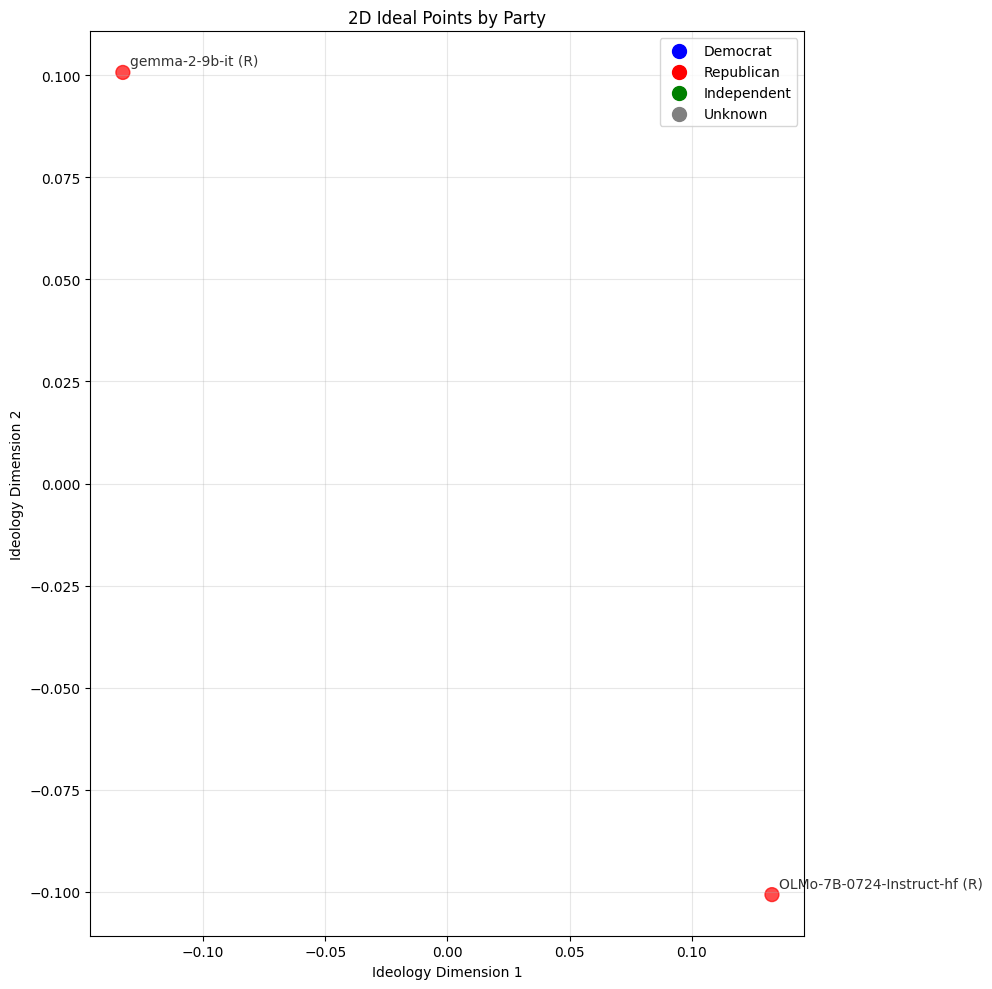

In [ ]:
"""
Create the ideal points plot matching R output

IRT CONNECTION: This visualizes the estimated person parameters (θ) in 2D space
Each point represents a legislator's estimated ideological position
"""
print("Creating plot...")

# Set up colors
party_colors = {'D': 'blue', 'R': 'red', 'I': 'green', 'U': 'grey'}
colors = [party_colors[party] for party in member_info_df['party']]

# Create plot
plt.figure(figsize=(10, 10))

# Scatter plot of ideal points (IRT person parameters)
plt.scatter(ideal_points[:, 0], ideal_points[:, 1], 
            c=colors, s=100, alpha=0.7)

# Add labels for each point
for i, row in member_info_df.iterrows():
    # Format name like R output: "LASTNAME (PARTY STATE)"
    name_parts = row['bioname'].split(', ')
    if len(name_parts) >= 2:
        lastname = name_parts[0]
    else:
        lastname = row['bioname']
    
    # label = f"{lastname} ({row['party']} {row['state_abbrev']})"
    label = f"{lastname} ({row['party']})"
    
    plt.annotate(label, 
                (ideal_points[i, 0], ideal_points[i, 1]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, alpha=0.8, rotation=0)

# Formatting
plt.xlabel('Ideology Dimension 1')  # First IRT dimension (usually liberal-conservative)
plt.ylabel('Ideology Dimension 2')  # Second IRT dimension
plt.title('2D Ideal Points by Party')

# Legend
legend_elements = [
    plt.scatter([], [], c='blue', s=100, label='Democrat'),
    plt.scatter([], [], c='red', s=100, label='Republican'),
    plt.scatter([], [], c='green', s=100, label='Independent'),
    plt.scatter([], [], c='grey', s=100, label='Unknown')
]
plt.legend(handles=legend_elements)#, loc='upper left'

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Summary

In [ ]:
print("\nSummary by party:")
for party in ['D', 'R', 'I', 'U']:
    party_mask = member_info_df['party'] == party
    if party_mask.any():
        party_points = ideal_points[party_mask]
        print(f"{party}: n={np.sum(party_mask)}, "
                f"Dim1 mean={np.mean(party_points[:, 0]):.3f}, "
                f"Dim2 mean={np.mean(party_points[:, 1]):.3f}")

print("\nIRT-based ideal point analysis complete!")